In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Reed Thunstrom 
__Class:__ DAMLAS Summer 2016
__Email:__ reed.thunstrom@target.com
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Spark is a veneer for the HDFS file system.  While hadoop distributes the processing across disk, Spark using distributed memory and hence is much faster.  However, because it' using memory, we need to be careful with how we set up our jobs ie not send huge files back to the edge nodes.

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, ___ BLANKS __ languages (list languages). __ 

Python and Scala
<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or ????? in a distributed manner. __

SparkContext or SC.  This can be used to parallelize data on the cluster when running spark.

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

An RDD is a resilient distributed dataset. It's a partitioned collection of elements that can be operated on in parallel.
<hr>


In [101]:
fundata = ['Jimi', 'is', 'swell']
funRDD = sc.parallelize(fundata)
funRDD.take(1)

['Jimi']

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [9]:
import os
import sys #current as of 9/26/2015

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print (sc)
print (sqlContext)


# Import some libraries to work with dates
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=example-logs, master=local[*]) created by __init__ at <ipython-input-1-22e947500b18>:12 

In [10]:
#top 20
logFileNAME = 'HW3.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a:a[1], 0)
wordCounts = counts.collect()
for v in counts.take(20):
    print (v)

('the', 71)
('', 68)
('of', 49)
('and', 40)
('to', 33)
('in', 32)
('##', 27)
('a', 23)
('this', 17)
('Contents', 17)
('for', 17)
('Table', 17)
('Back', 16)
('with', 14)
('as', 13)
('KMeans', 12)
('&', 12)
('data', 12)
('model', 11)
('here', 11)


In [9]:
#Bottom 10
logFileNAME = 'HW3.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a:a[1], 1)
wordCounts = counts.collect()
for v in wordCounts[:10]:
    print (v)

('HW3', 1)
('50,', 1)
('appears', 1)
('driver', 1)
('3.6.1', 1)
('implentation', 1)
('At', 1)
('iterations', 1)
('Matei.', 1)
('make', 1)


<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [9]:
#top 20
logFileNAME = 'HW3.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" "))
filter_text = counts.filter(lambda x: x.islower()) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a:a[1], 0)
wordCounts = filter_text.collect()
for v in wordCounts:
    print (v)

('the', 71)
('of', 49)
('and', 40)
('to', 33)
('in', 32)
('a', 23)
('this', 17)
('for', 17)
('with', 14)
('as', 13)
('data', 12)
('model', 11)
('code', 11)
('here', 11)
('is', 10)
('plot', 10)
('goes', 9)
('your', 8)
('linear', 7)
('each', 7)
('notebook', 7)
('from', 7)
('on', 7)
('domain', 6)
('following', 6)
('regression', 6)
('clusters', 5)
('training', 5)
('one', 5)
('provided', 5)
('it', 5)
('more', 4)
('using', 4)
('space', 4)
('at', 4)
('side', 4)
('notebooks', 4)
('words', 4)
('submissions', 4)
('import', 3)
('after', 3)
('count', 3)
('incorporate', 3)
('master', 3)
('homegrown', 3)
('referenced', 3)
('above', 3)
('cells', 3)
('plots', 3)
('just', 3)
('results', 3)
('into', 3)
('comprise', 3)
('iteration', 3)
('document', 3)
('submission.', 3)
('by', 3)
('directly', 3)
('that', 3)
('example', 3)
('show', 3)
('x', 3)
('should', 3)
('function', 3)
('report', 3)
('frequent', 3)
('most', 3)
('all', 3)
('provide', 2)
('free', 2)
('only]', 2)
('where', 2)
('vector', 2)
('work', 2)
('

<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [11]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10, runs=10, initializationMode="random")
for centroid in clusters.centers:
    print (centroid)

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

"""
# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")
"""

/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


[ 0.1  0.1  0.1]
[ 9.1  9.1  9.1]
Within Set Sum of Squared Error = 0.6928203230275529


'\n# Save and load model\nclusters.save(sc, "myModelPath")\nsameModel = KMeansModel.load(sc, "myModelPath")\n'

#### COMMENTS

We notice a very small error at 0.6928.  This is due to the fact that the data is very small, concise, and basically clustering into two distinct groups.  Therefore the algorithm can find the grouping quickly and accurately.   Larger data sets will be useful to analyze later to see how fast we converge and see drops in the error.

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [74]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('kmeans2_data.txt',data,delimiter = ',')

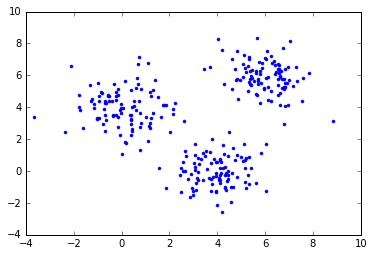

In [68]:
pylab.plot(data[:, 0], data[:, 1], '.', color = 'blue')
pylab.show()

[ 2.17536389  5.0336421 ]
[ 5.02968999  3.69541645]
[ 3.95140013 -0.25787428]
Within Set Sum of Squared Error = 665.9508120832659


/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


[ 3.87527608  0.11408864]
[-0.04364292  3.95200914]
[ 5.9744049   6.06374972]
Within Set Sum of Squared Error = 378.1981959539458
[ 3.87527608  0.11408864]
[ 5.9744049   6.06374972]
[-0.04364292  3.95200914]
Within Set Sum of Squared Error = 378.1981959539458
[-0.04364292  3.95200914]
[ 3.87527608  0.11408864]
[ 5.9744049   6.06374972]
Within Set Sum of Squared Error = 378.1981959539458
[ 3.87527608  0.11408864]
[-0.04364292  3.95200914]
[ 5.9744049   6.06374972]
Within Set Sum of Squared Error = 378.1981959539458
[ 3.87527608  0.11408864]
[-0.04364292  3.95200914]
[ 5.9744049   6.06374972]
Within Set Sum of Squared Error = 378.1981959539458
[ 3.87527608  0.11408864]
[ 5.9744049   6.06374972]
[-0.04364292  3.95200914]
Within Set Sum of Squared Error = 378.1981959539458


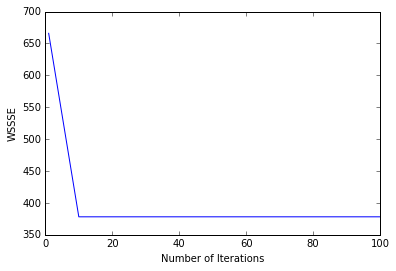

In [88]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans2_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
x = [1, 10, 20, 30, 40, 50, 100]
errorlist = []
for i in x:
    clusters = KMeans.train(parsedData, 3, maxIterations=i, runs=i, initializationMode="random")
    for centroid in clusters.centers:
        print (centroid)
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    errorlist += (x, WSSSE)

import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[3], errorlist[5], errorlist[7], errorlist[9], errorlist[11], errorlist[13]
xaxis = 1, 10, 20, 30, 40, 50, 100
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()


<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

In [56]:
%matplotlib inline
import numpy as np
import pylab 

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()
def error(point):
    x = np.array([float(f) for f in point.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    error_amount = sqrt(np.sum((x - centroids[closest_centroid_idx])**2))
    return (error_amount)

Iteration0
[[ 1.2359698   0.12597424]
 [ 4.00551001  2.70722078]
 [ 1.90963734  5.75295223]]


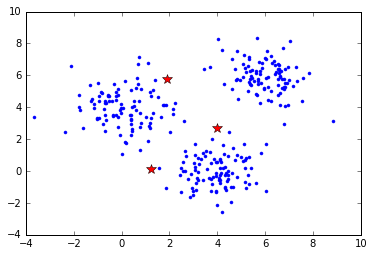

Within Set Sum of Squared Error = 1071.9204041843823
Iteration1
[[ 2.38293855  0.32190987]
 [ 5.46472781  3.2359433 ]
 [ 1.86593191  5.20642265]]


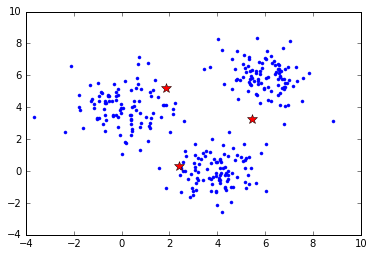

Within Set Sum of Squared Error = 862.0633303244686
Iteration2
[[ 3.49561018 -0.01484962]
 [ 6.01945515  5.2312626 ]
 [ 0.47609436  4.45725963]]


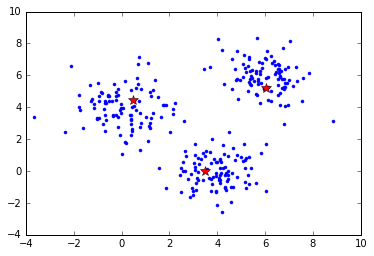

Within Set Sum of Squared Error = 708.3387908274616
Iteration3
[[  3.92225691e+00  -4.62734024e-03]
 [  5.99919518e+00   5.92732777e+00]
 [  7.67729452e-02   3.99305346e+00]]


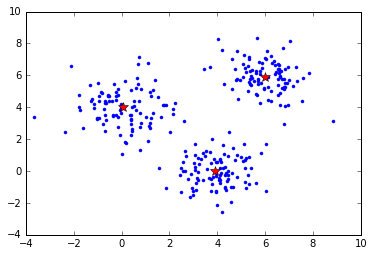

Within Set Sum of Squared Error = 412.65825648742714
Iteration4
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


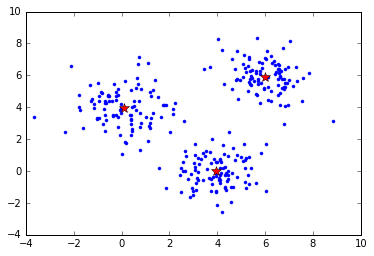

Within Set Sum of Squared Error = 376.16521573281625
Iteration5
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


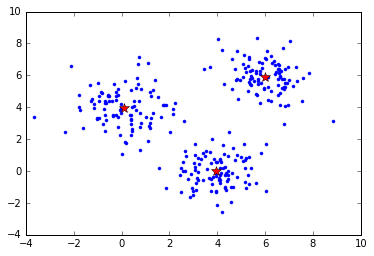

Within Set Sum of Squared Error = 375.9815569553383
Iteration6
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


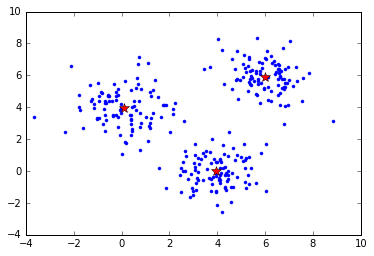

Within Set Sum of Squared Error = 375.9815569553383
Iteration7
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


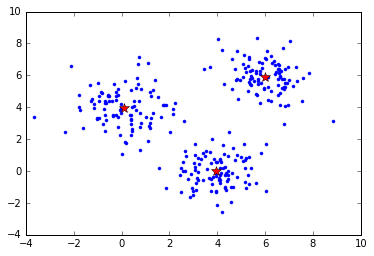

Within Set Sum of Squared Error = 375.9815569553383
Iteration8
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


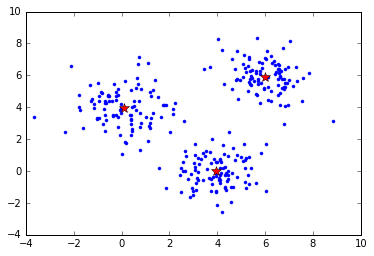

Within Set Sum of Squared Error = 375.9815569553383
Iteration9
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


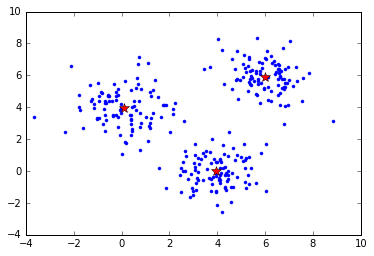

Within Set Sum of Squared Error = 375.9815569553383
Iteration10
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


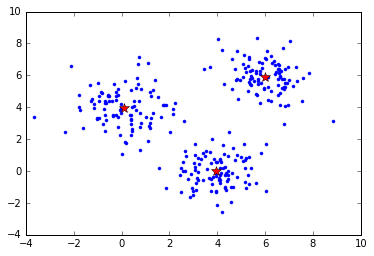

Within Set Sum of Squared Error = 375.9815569553383
Iteration11
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


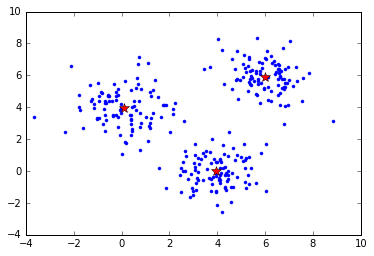

Within Set Sum of Squared Error = 375.9815569553383
Iteration12
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


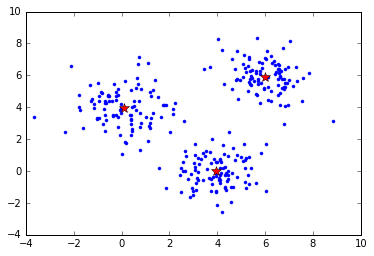

Within Set Sum of Squared Error = 375.9815569553383
Iteration13
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


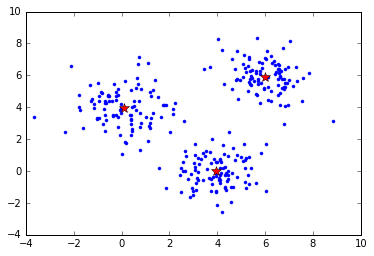

Within Set Sum of Squared Error = 375.9815569553383
Iteration14
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


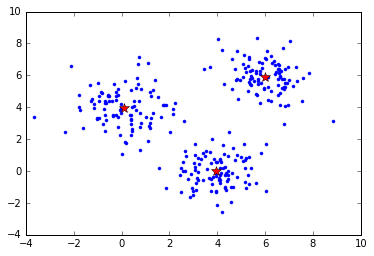

Within Set Sum of Squared Error = 375.9815569553383
Iteration15
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


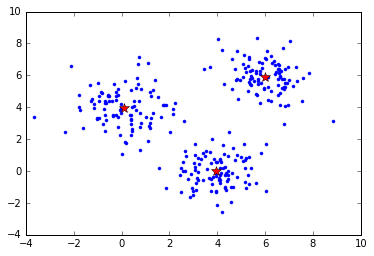

Within Set Sum of Squared Error = 375.9815569553383
Iteration16
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


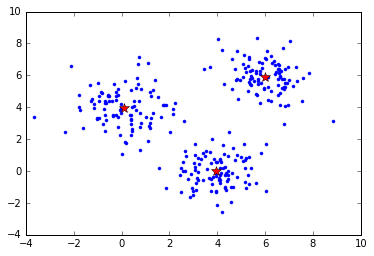

Within Set Sum of Squared Error = 375.9815569553383
Iteration17
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


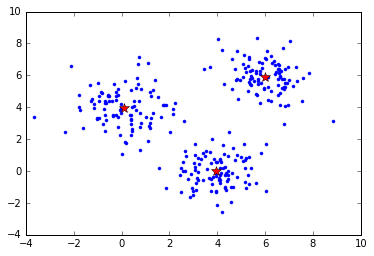

Within Set Sum of Squared Error = 375.9815569553383
Iteration18
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


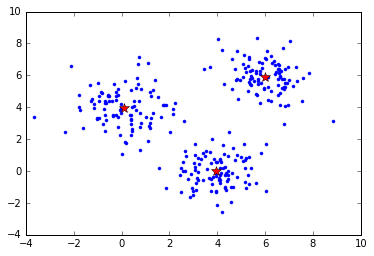

Within Set Sum of Squared Error = 375.9815569553383
Iteration19
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


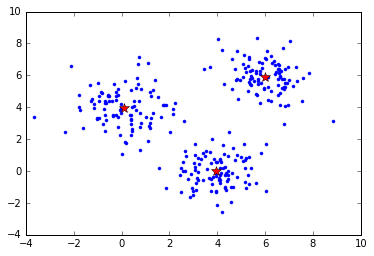

Within Set Sum of Squared Error = 375.9815569553383
Iteration20
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


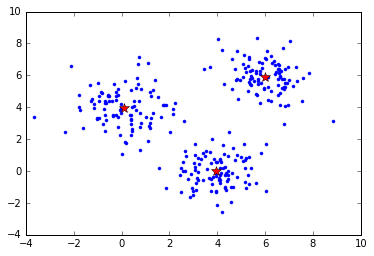

Within Set Sum of Squared Error = 375.9815569553383
Iteration21
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


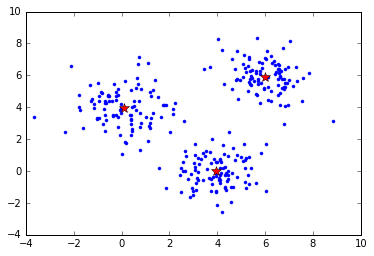

Within Set Sum of Squared Error = 375.9815569553383
Iteration22
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


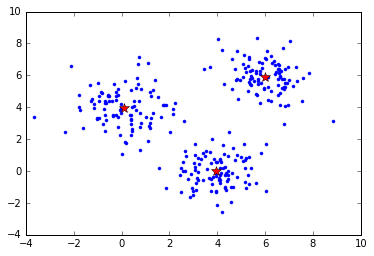

Within Set Sum of Squared Error = 375.9815569553383
Iteration23
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


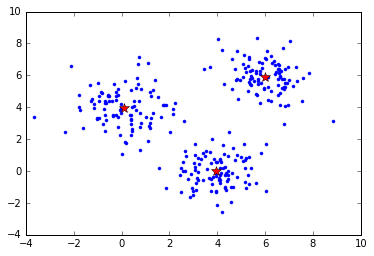

Within Set Sum of Squared Error = 375.9815569553383
Iteration24
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


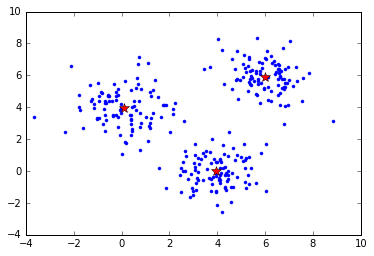

Within Set Sum of Squared Error = 375.9815569553383
Iteration25
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


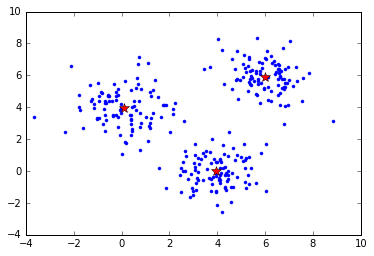

Within Set Sum of Squared Error = 375.9815569553383
Iteration26
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


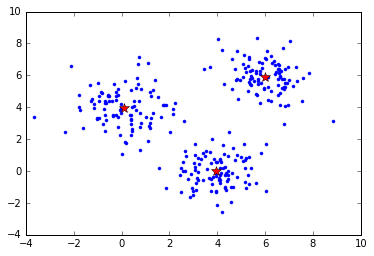

Within Set Sum of Squared Error = 375.9815569553383
Iteration27
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


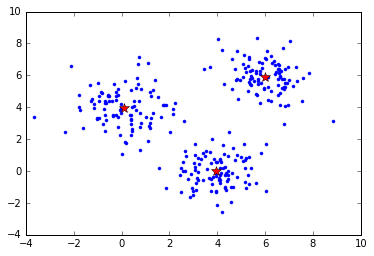

Within Set Sum of Squared Error = 375.9815569553383
Iteration28
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


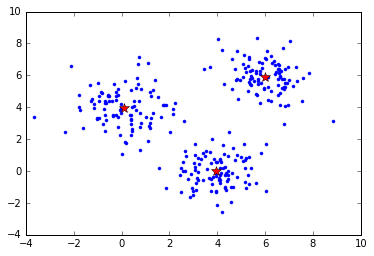

Within Set Sum of Squared Error = 375.9815569553383
Iteration29
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


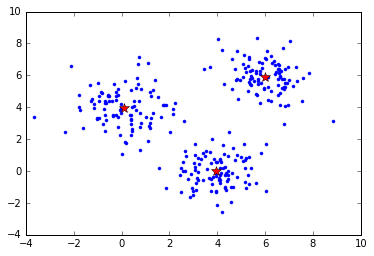

Within Set Sum of Squared Error = 375.9815569553383
Iteration30
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


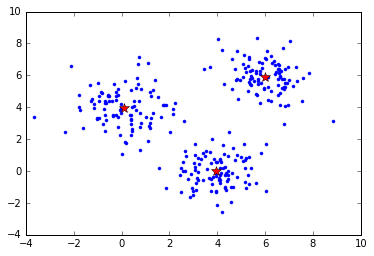

Within Set Sum of Squared Error = 375.9815569553383
Iteration31
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


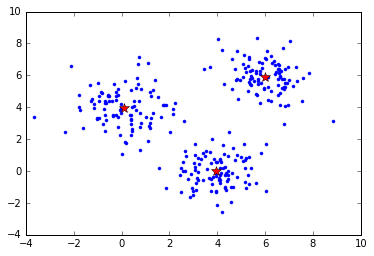

Within Set Sum of Squared Error = 375.9815569553383
Iteration32
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


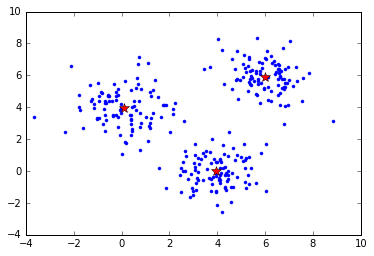

Within Set Sum of Squared Error = 375.9815569553383
Iteration33
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


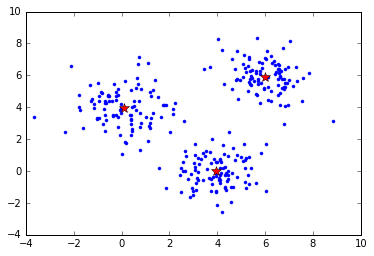

Within Set Sum of Squared Error = 375.9815569553383
Iteration34
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


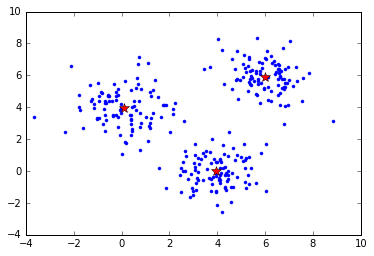

Within Set Sum of Squared Error = 375.9815569553383
Iteration35
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


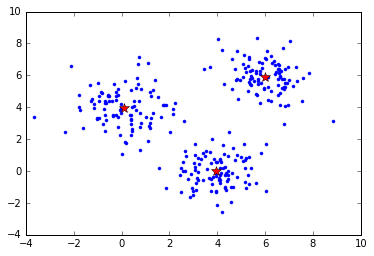

Within Set Sum of Squared Error = 375.9815569553383
Iteration36
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


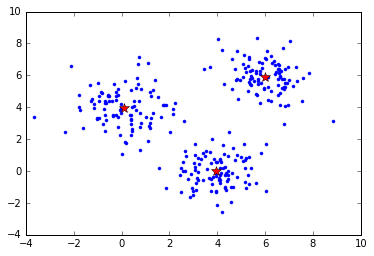

Within Set Sum of Squared Error = 375.9815569553383
Iteration37
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


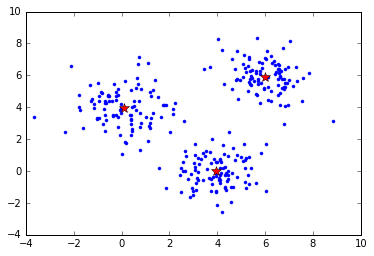

Within Set Sum of Squared Error = 375.9815569553383
Iteration38
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


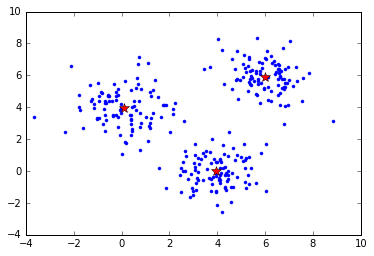

Within Set Sum of Squared Error = 375.9815569553383
Iteration39
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


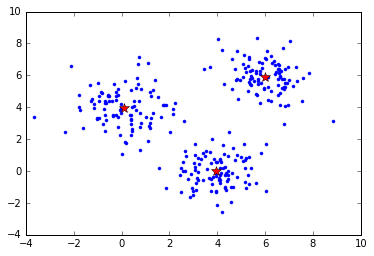

Within Set Sum of Squared Error = 375.9815569553383
Iteration40
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


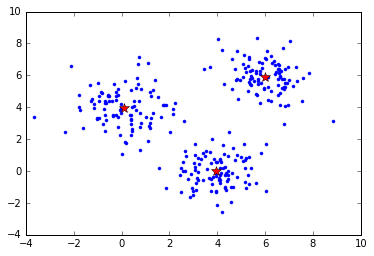

Within Set Sum of Squared Error = 375.9815569553383
Iteration41
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


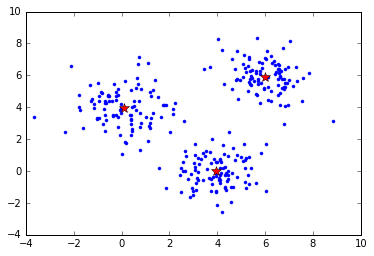

Within Set Sum of Squared Error = 375.9815569553383
Iteration42
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


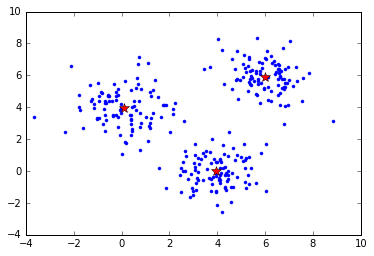

Within Set Sum of Squared Error = 375.9815569553383
Iteration43
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


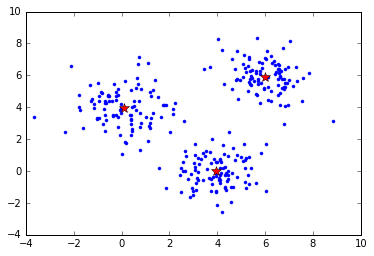

Within Set Sum of Squared Error = 375.9815569553383
Iteration44
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


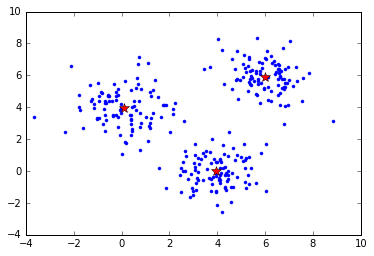

Within Set Sum of Squared Error = 375.9815569553383
Iteration45
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


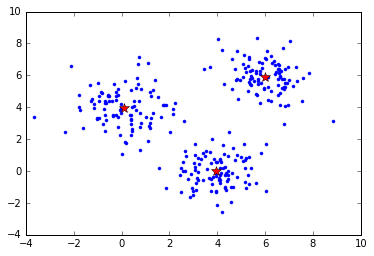

Within Set Sum of Squared Error = 375.9815569553383
Iteration46
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


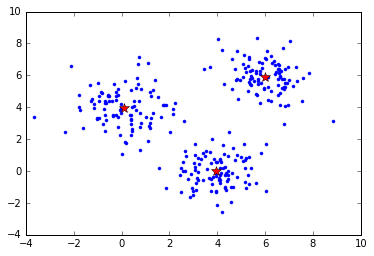

Within Set Sum of Squared Error = 375.9815569553383
Iteration47
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


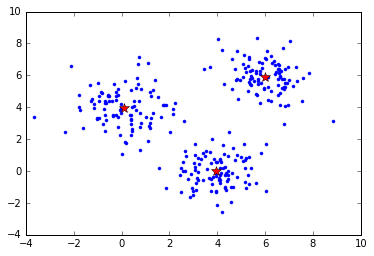

Within Set Sum of Squared Error = 375.9815569553383
Iteration48
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


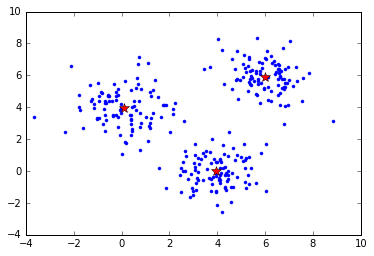

Within Set Sum of Squared Error = 375.9815569553383
Iteration49
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


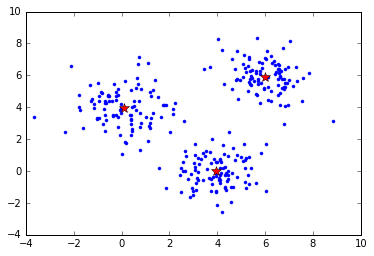

Within Set Sum of Squared Error = 375.9815569553383
Iteration50
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


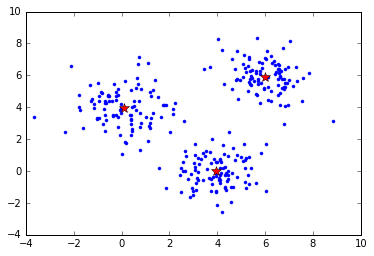

Within Set Sum of Squared Error = 375.9815569553383
Iteration51
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


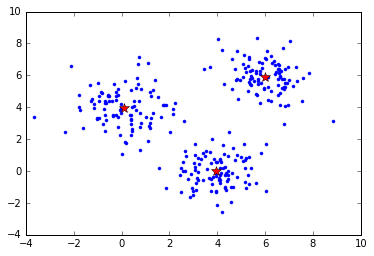

Within Set Sum of Squared Error = 375.9815569553383
Iteration52
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


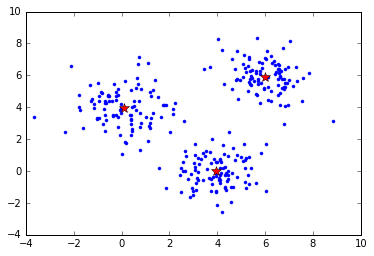

Within Set Sum of Squared Error = 375.9815569553383
Iteration53
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


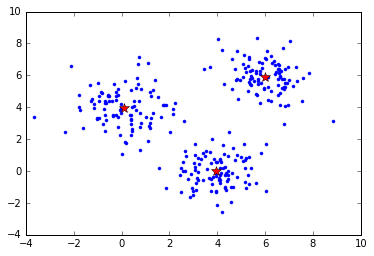

Within Set Sum of Squared Error = 375.9815569553383
Iteration54
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


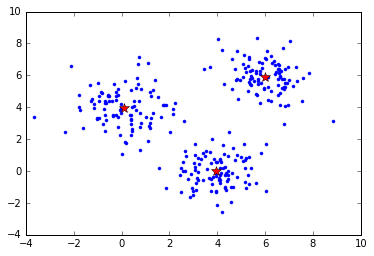

Within Set Sum of Squared Error = 375.9815569553383
Iteration55
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


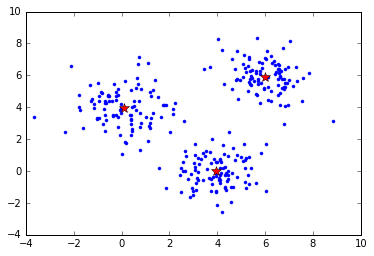

Within Set Sum of Squared Error = 375.9815569553383
Iteration56
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


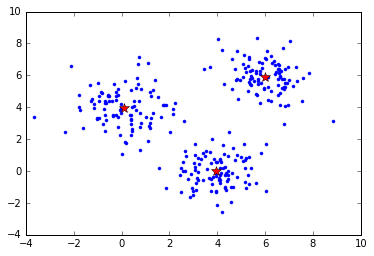

Within Set Sum of Squared Error = 375.9815569553383
Iteration57
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


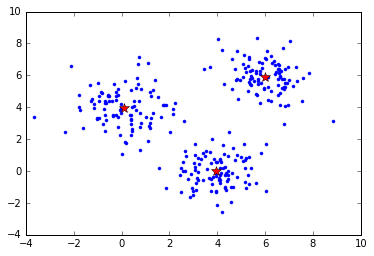

Within Set Sum of Squared Error = 375.9815569553383
Iteration58
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


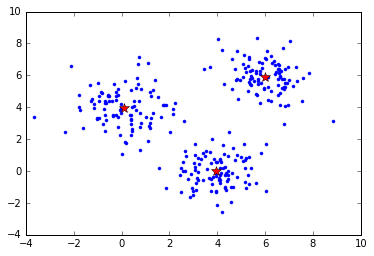

Within Set Sum of Squared Error = 375.9815569553383
Iteration59
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


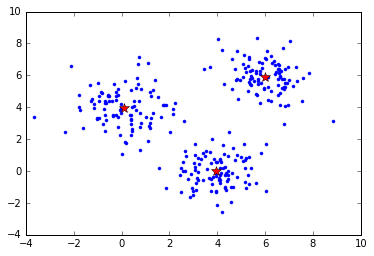

Within Set Sum of Squared Error = 375.9815569553383
Iteration60
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


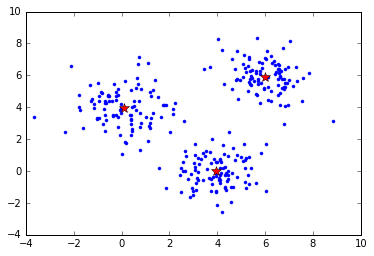

Within Set Sum of Squared Error = 375.9815569553383
Iteration61
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


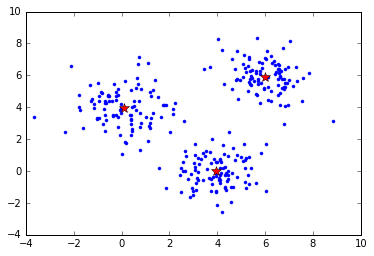

Within Set Sum of Squared Error = 375.9815569553383
Iteration62
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


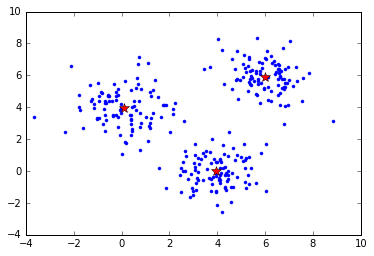

Within Set Sum of Squared Error = 375.9815569553383
Iteration63
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


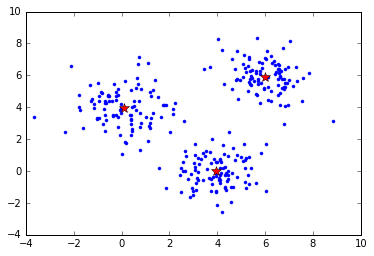

Within Set Sum of Squared Error = 375.9815569553383
Iteration64
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


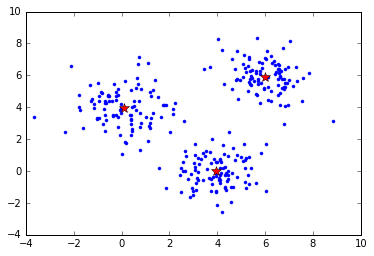

Within Set Sum of Squared Error = 375.9815569553383
Iteration65
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


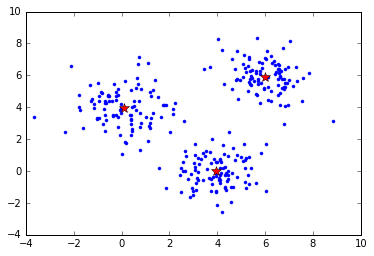

Within Set Sum of Squared Error = 375.9815569553383
Iteration66
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


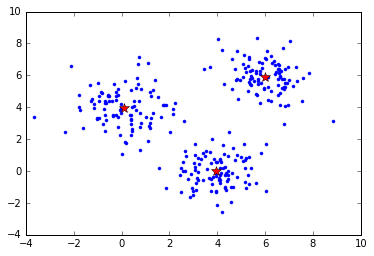

Within Set Sum of Squared Error = 375.9815569553383
Iteration67
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


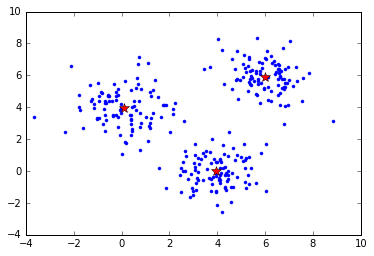

Within Set Sum of Squared Error = 375.9815569553383
Iteration68
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


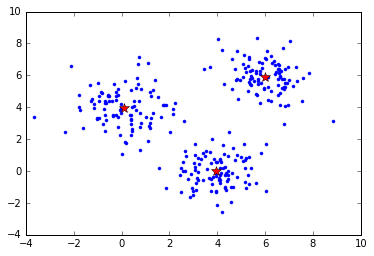

Within Set Sum of Squared Error = 375.9815569553383
Iteration69
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


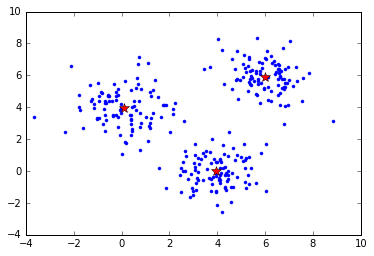

Within Set Sum of Squared Error = 375.9815569553383
Iteration70
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


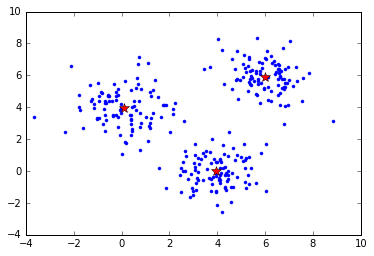

Within Set Sum of Squared Error = 375.9815569553383
Iteration71
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


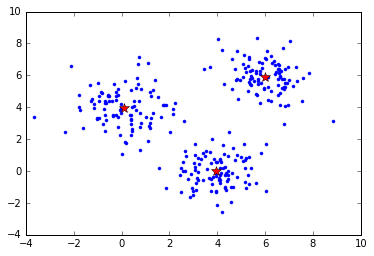

Within Set Sum of Squared Error = 375.9815569553383
Iteration72
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


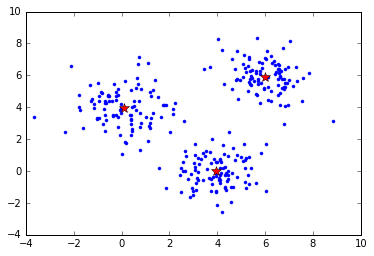

Within Set Sum of Squared Error = 375.9815569553383
Iteration73
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


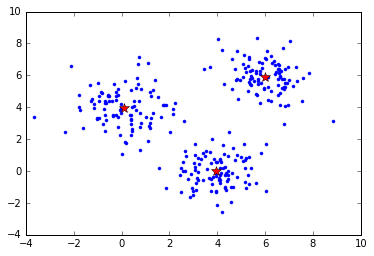

Within Set Sum of Squared Error = 375.9815569553383
Iteration74
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


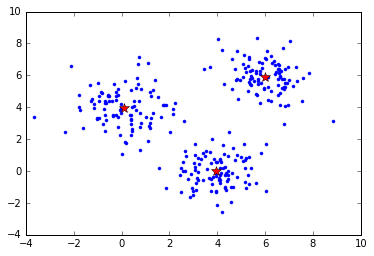

Within Set Sum of Squared Error = 375.9815569553383
Iteration75
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


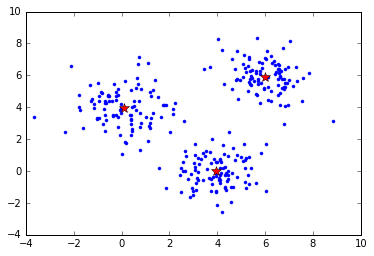

Within Set Sum of Squared Error = 375.9815569553383
Iteration76
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


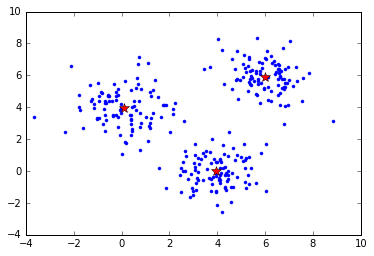

Within Set Sum of Squared Error = 375.9815569553383
Iteration77
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


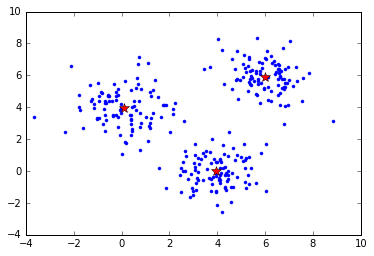

Within Set Sum of Squared Error = 375.9815569553383
Iteration78
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


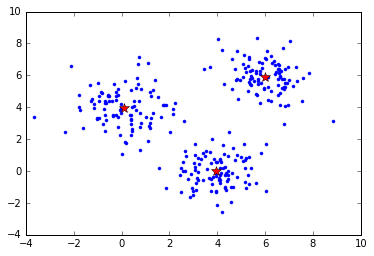

Within Set Sum of Squared Error = 375.9815569553383
Iteration79
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


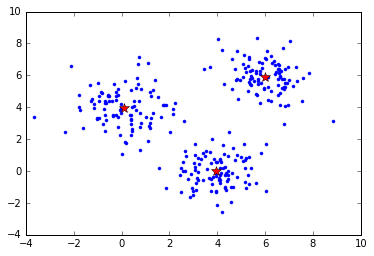

Within Set Sum of Squared Error = 375.9815569553383
Iteration80
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


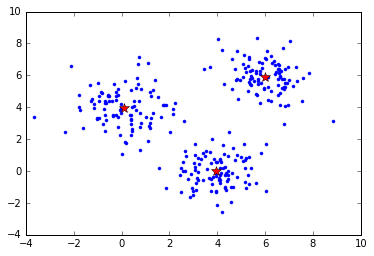

Within Set Sum of Squared Error = 375.9815569553383
Iteration81
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


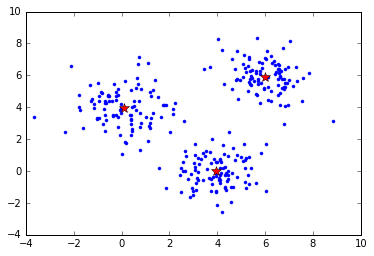

Within Set Sum of Squared Error = 375.9815569553383
Iteration82
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


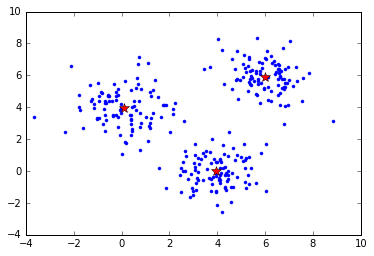

Within Set Sum of Squared Error = 375.9815569553383
Iteration83
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


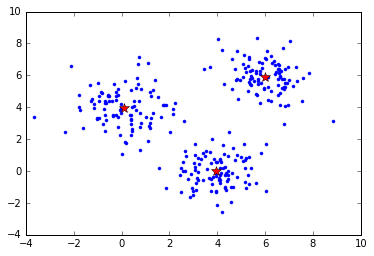

Within Set Sum of Squared Error = 375.9815569553383
Iteration84
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


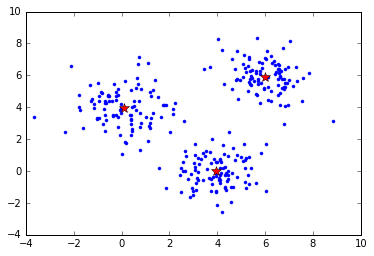

Within Set Sum of Squared Error = 375.9815569553383
Iteration85
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


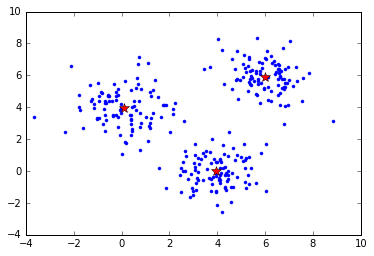

Within Set Sum of Squared Error = 375.9815569553383
Iteration86
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


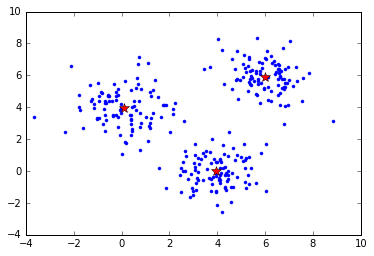

Within Set Sum of Squared Error = 375.9815569553383
Iteration87
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


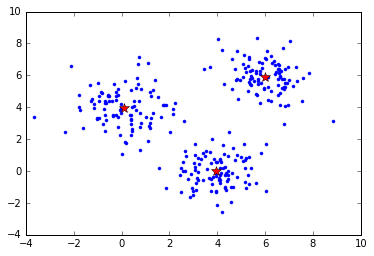

Within Set Sum of Squared Error = 375.9815569553383
Iteration88
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


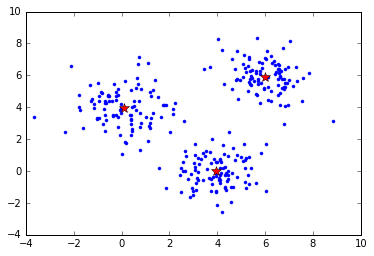

Within Set Sum of Squared Error = 375.9815569553383
Iteration89
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


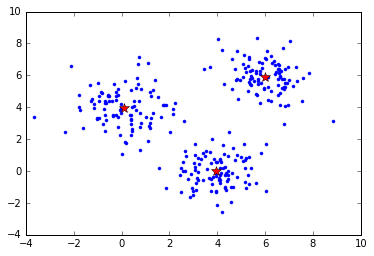

Within Set Sum of Squared Error = 375.9815569553383
Iteration90
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


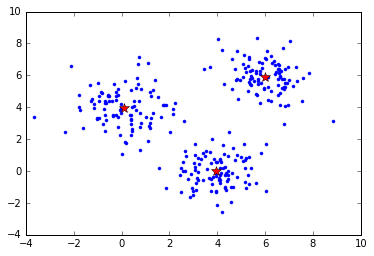

Within Set Sum of Squared Error = 375.9815569553383
Iteration91
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


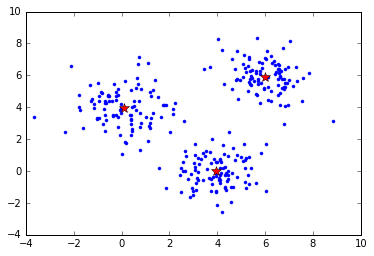

Within Set Sum of Squared Error = 375.9815569553383
Iteration92
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


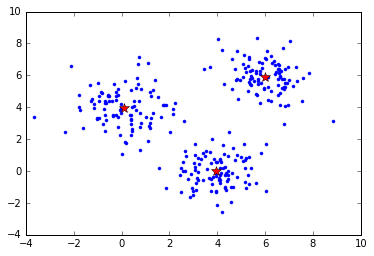

Within Set Sum of Squared Error = 375.9815569553383
Iteration93
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


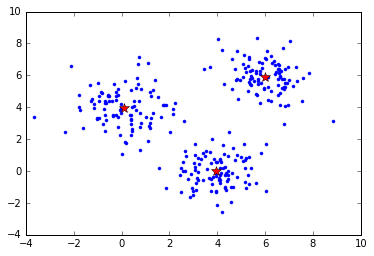

Within Set Sum of Squared Error = 375.9815569553383
Iteration94
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


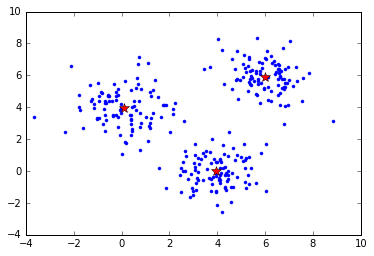

Within Set Sum of Squared Error = 375.9815569553383
Iteration95
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


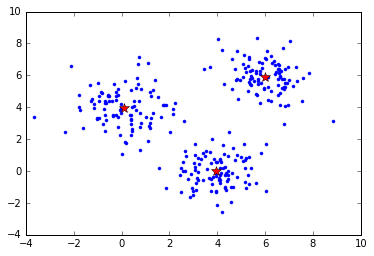

Within Set Sum of Squared Error = 375.9815569553383
Iteration96
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


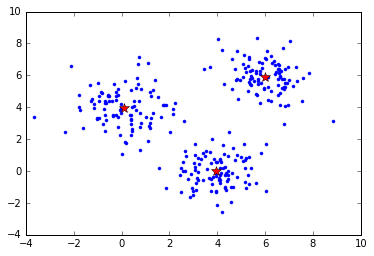

Within Set Sum of Squared Error = 375.9815569553383
Iteration97
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


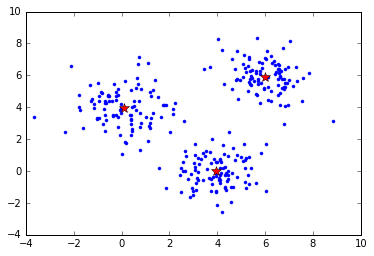

Within Set Sum of Squared Error = 375.9815569553383
Iteration98
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


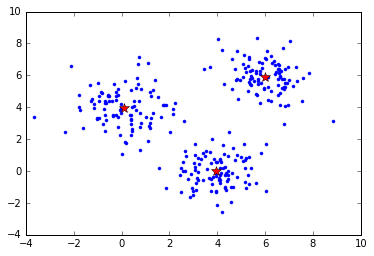

Within Set Sum of Squared Error = 375.9815569553383
Iteration99
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


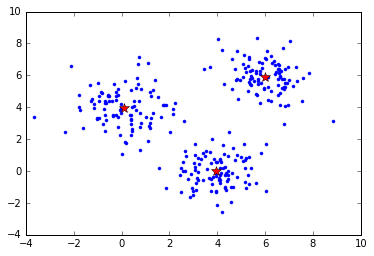

Within Set Sum of Squared Error = 375.9815569553383
Final Results:
[[ 3.95362168 -0.01798153]
 [ 5.99919518  5.92732777]
 [ 0.08386301  3.96643084]]


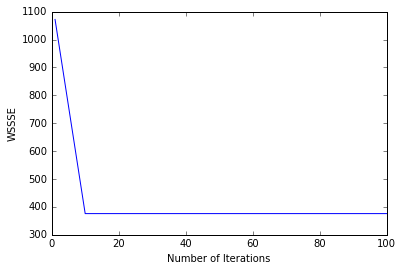

In [66]:
import numpy as np
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("kmeans2_data.txt").cache()
parsedData2 = D.map(lambda line: array([float(x) for x in line.split(' ')]))

iter_num = 0
errorlist = []
for i in range(100):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    errorval = D.map(error).reduce(lambda x, y: (x+y))
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    print ("Iteration" + str(iter_num))
    errorlist += (iter_num, errorval)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print (centroids)
    plot_iteration(centroids)
    print("Within Set Sum of Squared Error = " + str(errorval))

print ("Final Results:")
print (centroids)

import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[19], errorlist[39], errorlist[59], errorlist[79], errorlist[99], errorlist[199]
xaxis = 1, 10, 20, 30, 40, 50, 100
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()

#### COMMENTS

In the MLLIB implementation of KMeans clustering, there was a noticeable drop in error from 1 iteration to 10 iterations.  However, after 10 iterations, there was no noticeable difference in error.  The small size of sample can be accurately clustering with a small amount of iterations.  

In the homegrown implementation, we notice the same trend.  We see a noticeable drop in error from 1 iterations to 10 but nearly no improvement after 10.  Again, this is most likely due to the small amount of points in our sample population.  

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [109]:
%matplotlib inline
import numpy as np
import pylab 

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - cBroadcast.value)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()
def error(point):
    x = np.array([float(f) for f in point.split(',')])
    closest_centroid_idx = np.sum((x - cBroadcast.value)**2, axis=1).argmin()
    error_amount = sqrt(np.sum((x - cBroadcast.value[closest_centroid_idx])**2))
    return (error_amount)

Iteration0
[[ 0.73526187  0.59434992]
 [ 3.82499032  2.74247894]
 [ 2.1959719   5.74873573]]


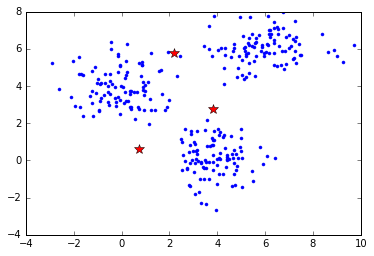

Within Set Sum of Squared Error = 1074.9408108359526
Iteration1
[[ 1.26267546  1.35319598]
 [ 5.08255555  2.35075642]
 [ 2.82094637  5.5405226 ]]


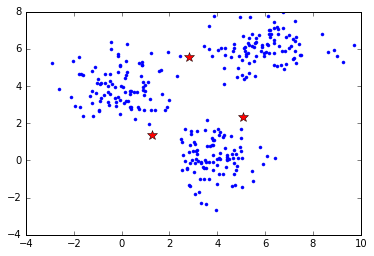

Within Set Sum of Squared Error = 886.5140824561865
Iteration2
[[ 1.06678449  2.01174703]
 [ 5.30020332  2.0240497 ]
 [ 3.91769256  5.93869522]]


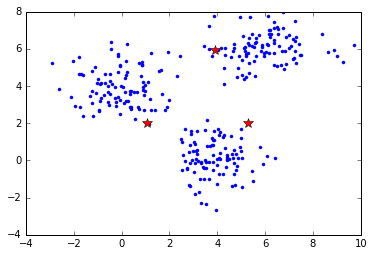

Within Set Sum of Squared Error = 818.6241049511746
Iteration3
[[ 0.52093705  2.97120586]
 [ 4.31028517  0.13043238]
 [ 5.51094559  6.01561163]]


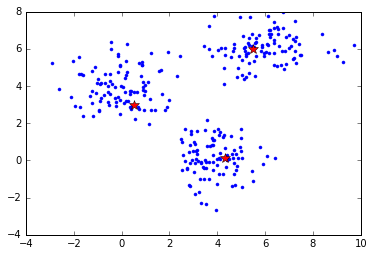

Within Set Sum of Squared Error = 711.6019256761572
Iteration4
[[-0.06871811  3.93534587]
 [ 3.87527608  0.11408864]
 [ 5.93939892  6.0591747 ]]


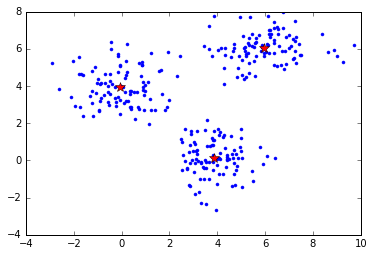

Within Set Sum of Squared Error = 420.0186616220029
Iteration5
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


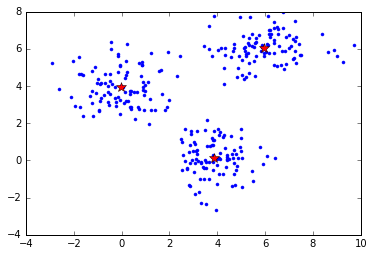

Within Set Sum of Squared Error = 378.03202794076844
Iteration6
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


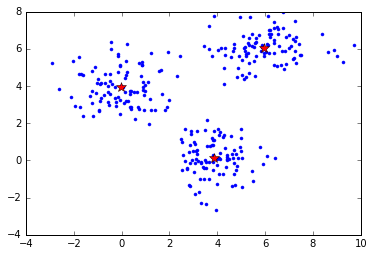

Within Set Sum of Squared Error = 378.1981959539458
Iteration7
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


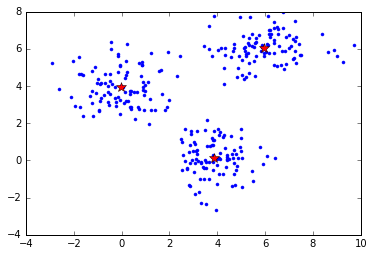

Within Set Sum of Squared Error = 378.1981959539458
Iteration8
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


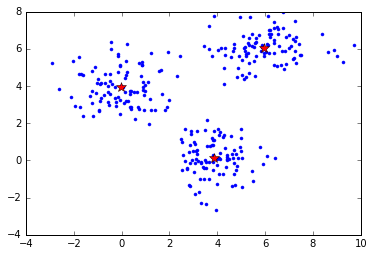

Within Set Sum of Squared Error = 378.1981959539458
Iteration9
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


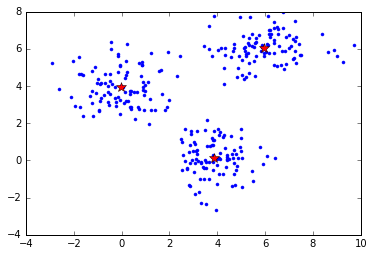

Within Set Sum of Squared Error = 378.1981959539458
Iteration10
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


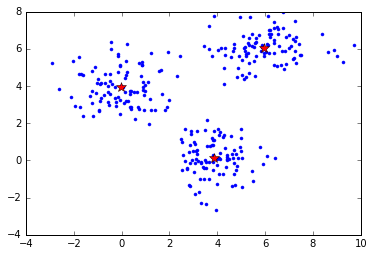

Within Set Sum of Squared Error = 378.1981959539458
Iteration11
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


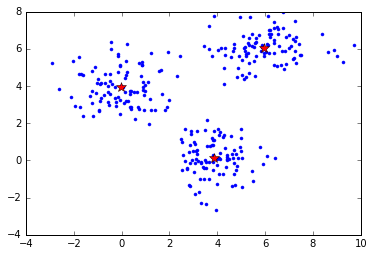

Within Set Sum of Squared Error = 378.1981959539458
Iteration12
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


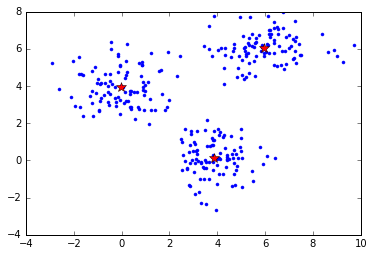

Within Set Sum of Squared Error = 378.1981959539458
Iteration13
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


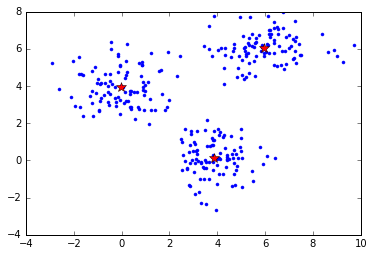

Within Set Sum of Squared Error = 378.1981959539458
Iteration14
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


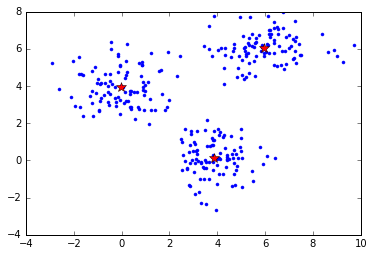

Within Set Sum of Squared Error = 378.1981959539458
Iteration15
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


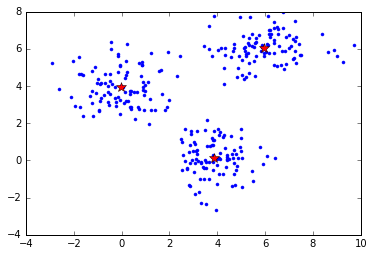

Within Set Sum of Squared Error = 378.1981959539458
Iteration16
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


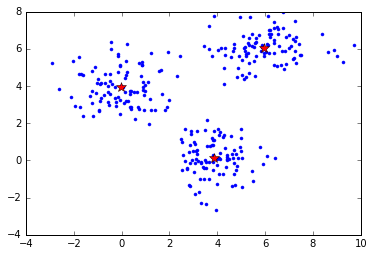

Within Set Sum of Squared Error = 378.1981959539458
Iteration17
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


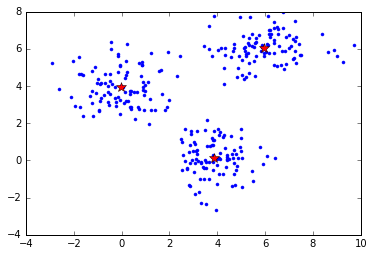

Within Set Sum of Squared Error = 378.1981959539458
Iteration18
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


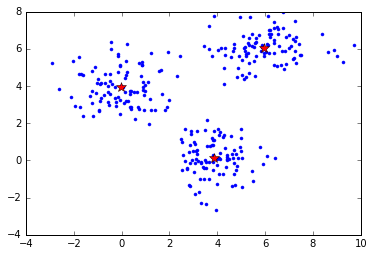

Within Set Sum of Squared Error = 378.1981959539458
Iteration19
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


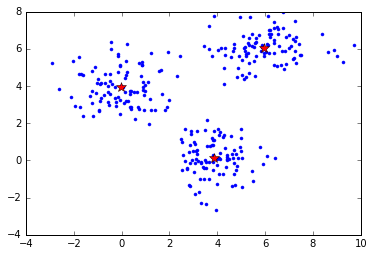

Within Set Sum of Squared Error = 378.1981959539458
Iteration20
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


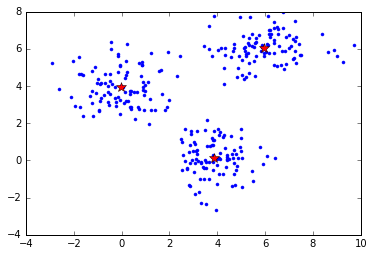

Within Set Sum of Squared Error = 378.1981959539458
Iteration21
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


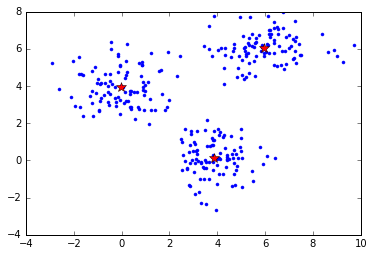

Within Set Sum of Squared Error = 378.1981959539458
Iteration22
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


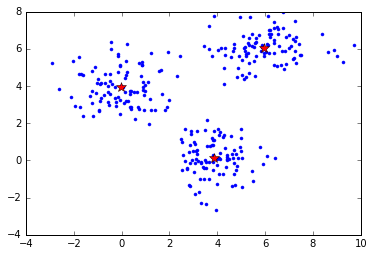

Within Set Sum of Squared Error = 378.1981959539458
Iteration23
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


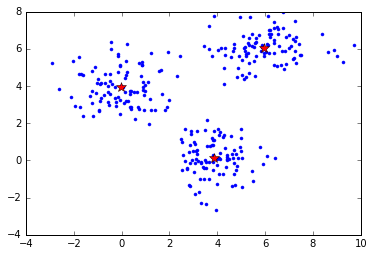

Within Set Sum of Squared Error = 378.1981959539458
Iteration24
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


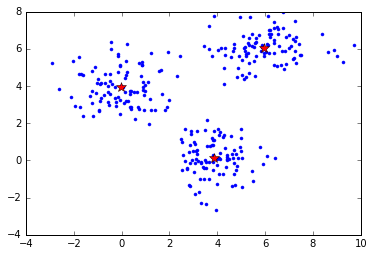

Within Set Sum of Squared Error = 378.1981959539458
Iteration25
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


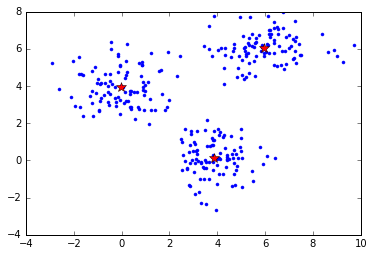

Within Set Sum of Squared Error = 378.1981959539458
Iteration26
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


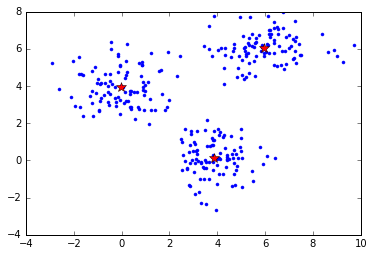

Within Set Sum of Squared Error = 378.1981959539458
Iteration27
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


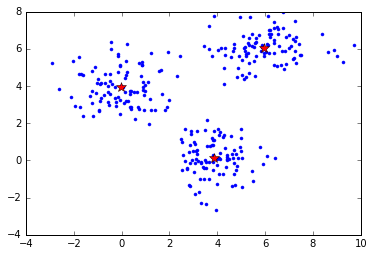

Within Set Sum of Squared Error = 378.1981959539458
Iteration28
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


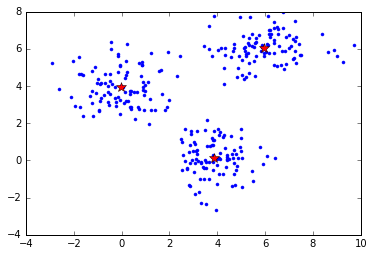

Within Set Sum of Squared Error = 378.1981959539458
Iteration29
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


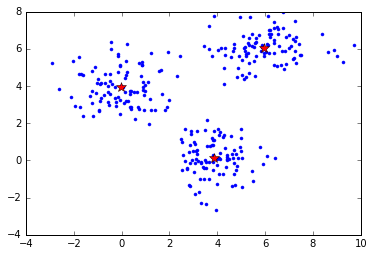

Within Set Sum of Squared Error = 378.1981959539458
Iteration30
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


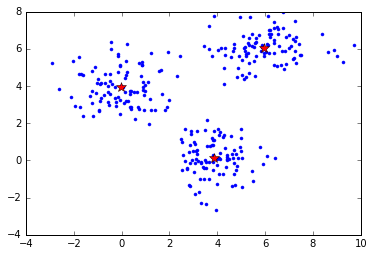

Within Set Sum of Squared Error = 378.1981959539458
Iteration31
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


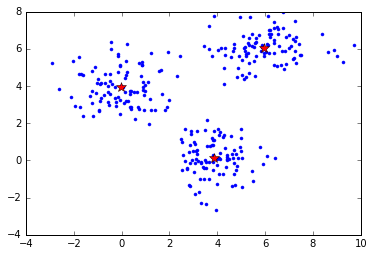

Within Set Sum of Squared Error = 378.1981959539458
Iteration32
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


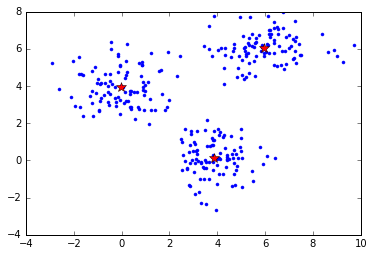

Within Set Sum of Squared Error = 378.1981959539458
Iteration33
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


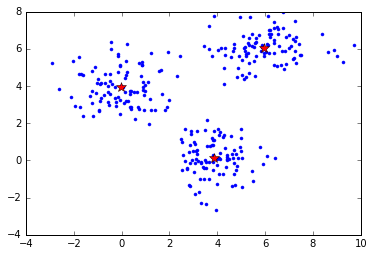

Within Set Sum of Squared Error = 378.1981959539458
Iteration34
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


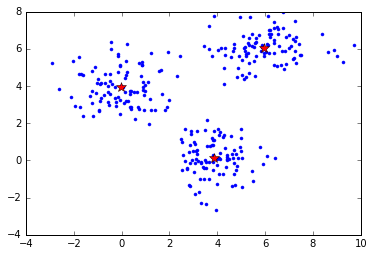

Within Set Sum of Squared Error = 378.1981959539458
Iteration35
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


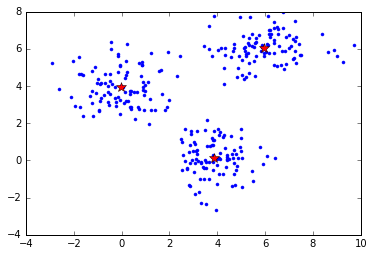

Within Set Sum of Squared Error = 378.1981959539458
Iteration36
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


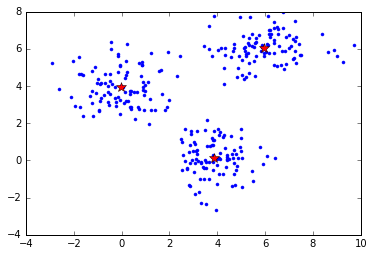

Within Set Sum of Squared Error = 378.1981959539458
Iteration37
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


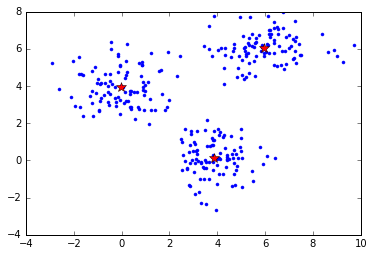

Within Set Sum of Squared Error = 378.1981959539458
Iteration38
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


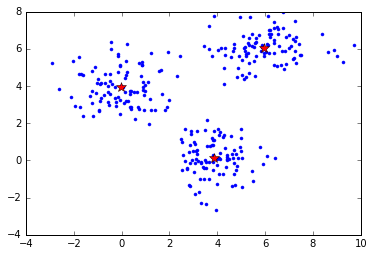

Within Set Sum of Squared Error = 378.1981959539458
Iteration39
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


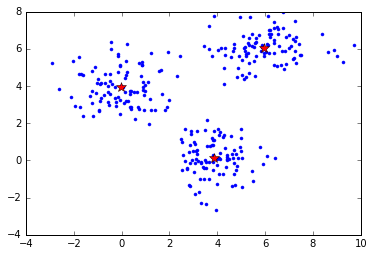

Within Set Sum of Squared Error = 378.1981959539458
Iteration40
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


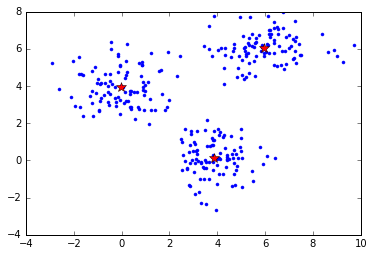

Within Set Sum of Squared Error = 378.1981959539458
Iteration41
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


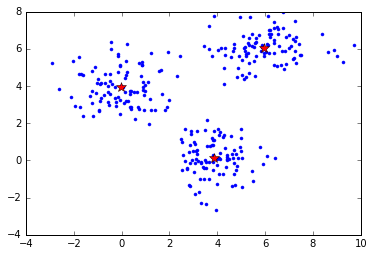

Within Set Sum of Squared Error = 378.1981959539458
Iteration42
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


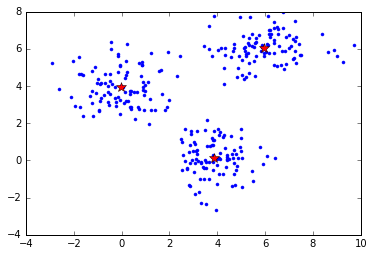

Within Set Sum of Squared Error = 378.1981959539458
Iteration43
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


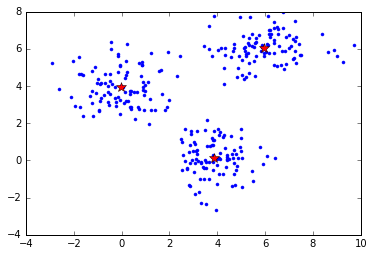

Within Set Sum of Squared Error = 378.1981959539458
Iteration44
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


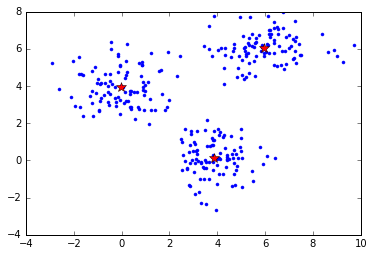

Within Set Sum of Squared Error = 378.1981959539458
Iteration45
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


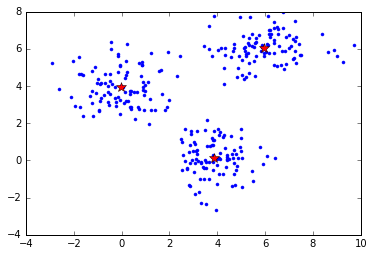

Within Set Sum of Squared Error = 378.1981959539458
Iteration46
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


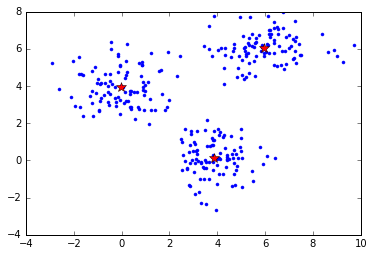

Within Set Sum of Squared Error = 378.1981959539458
Iteration47
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


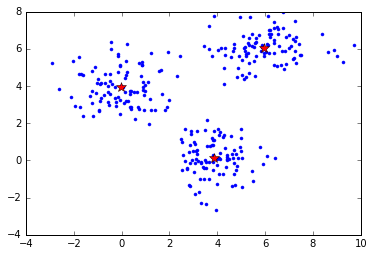

Within Set Sum of Squared Error = 378.1981959539458
Iteration48
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


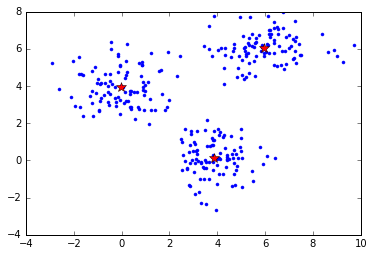

Within Set Sum of Squared Error = 378.1981959539458
Iteration49
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


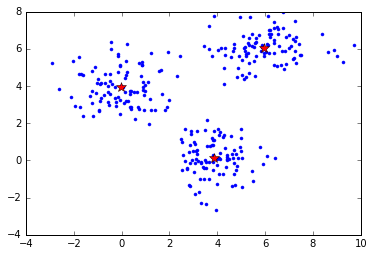

Within Set Sum of Squared Error = 378.1981959539458
Iteration50
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


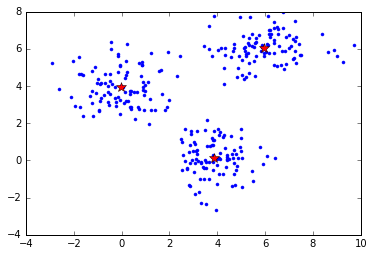

Within Set Sum of Squared Error = 378.1981959539458
Iteration51
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


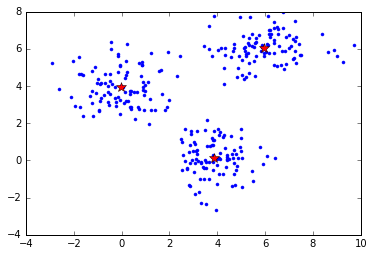

Within Set Sum of Squared Error = 378.1981959539458
Iteration52
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


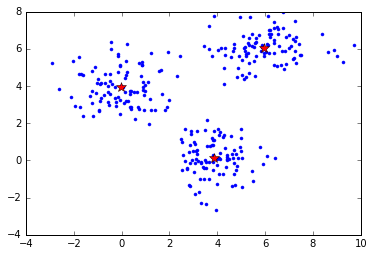

Within Set Sum of Squared Error = 378.1981959539458
Iteration53
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


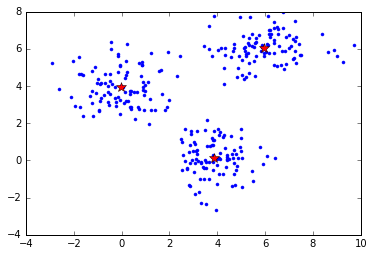

Within Set Sum of Squared Error = 378.1981959539458
Iteration54
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


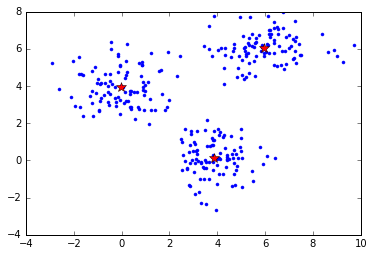

Within Set Sum of Squared Error = 378.1981959539458
Iteration55
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


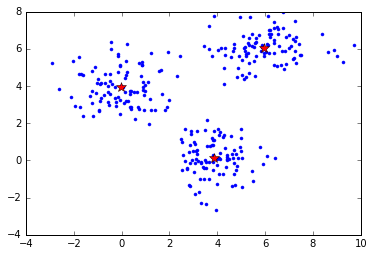

Within Set Sum of Squared Error = 378.1981959539458
Iteration56
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


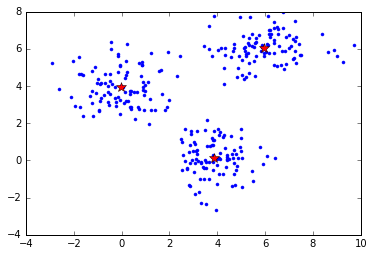

Within Set Sum of Squared Error = 378.1981959539458
Iteration57
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


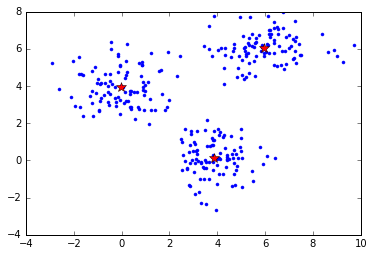

Within Set Sum of Squared Error = 378.1981959539458
Iteration58
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


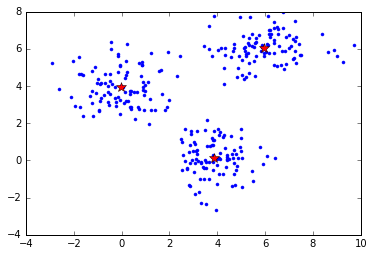

Within Set Sum of Squared Error = 378.1981959539458
Iteration59
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


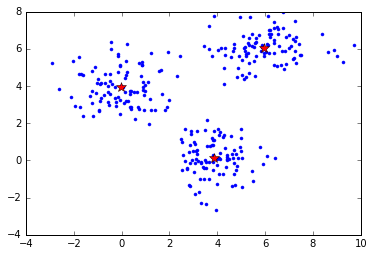

Within Set Sum of Squared Error = 378.1981959539458
Iteration60
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


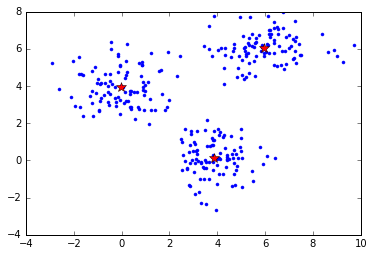

Within Set Sum of Squared Error = 378.1981959539458
Iteration61
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


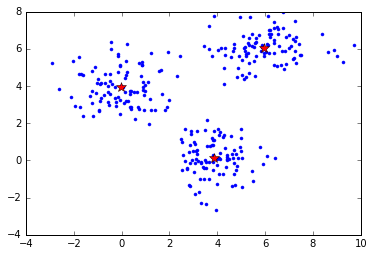

Within Set Sum of Squared Error = 378.1981959539458
Iteration62
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


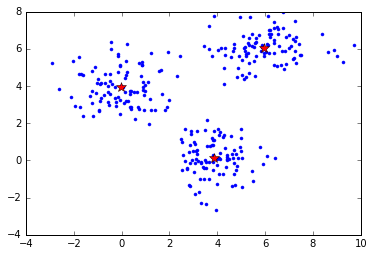

Within Set Sum of Squared Error = 378.1981959539458
Iteration63
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


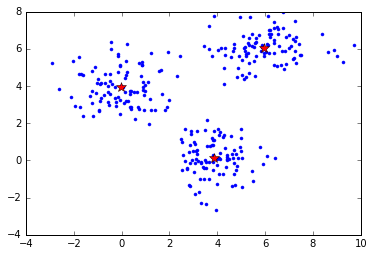

Within Set Sum of Squared Error = 378.1981959539458
Iteration64
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


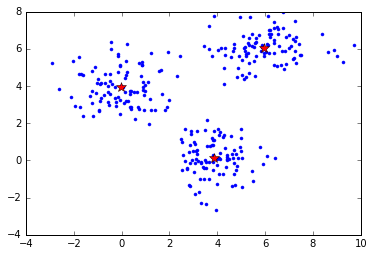

Within Set Sum of Squared Error = 378.1981959539458
Iteration65
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


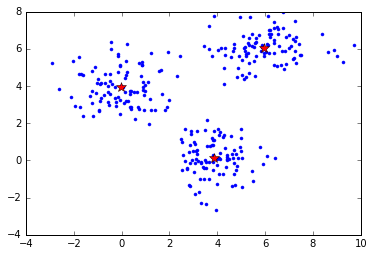

Within Set Sum of Squared Error = 378.1981959539458
Iteration66
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


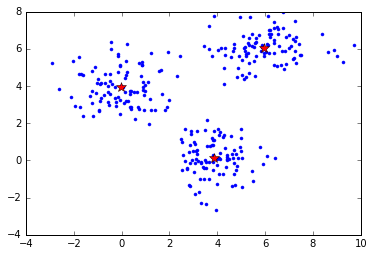

Within Set Sum of Squared Error = 378.1981959539458
Iteration67
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


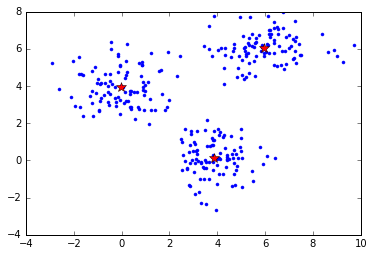

Within Set Sum of Squared Error = 378.1981959539458
Iteration68
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


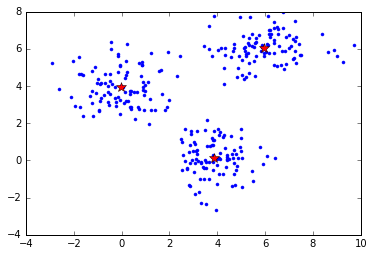

Within Set Sum of Squared Error = 378.1981959539458
Iteration69
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


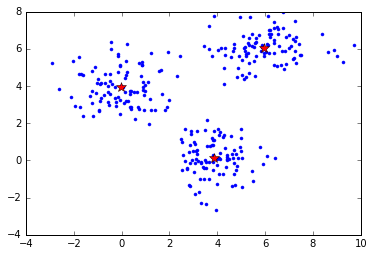

Within Set Sum of Squared Error = 378.1981959539458
Iteration70
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


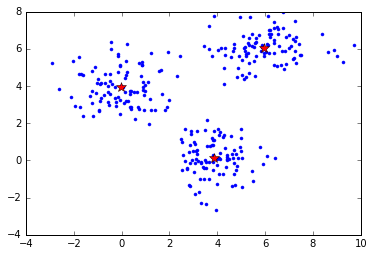

Within Set Sum of Squared Error = 378.1981959539458
Iteration71
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


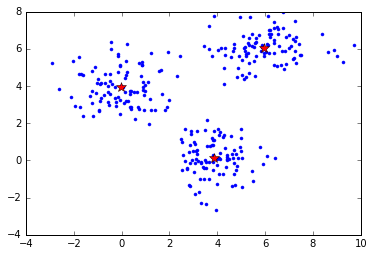

Within Set Sum of Squared Error = 378.1981959539458
Iteration72
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


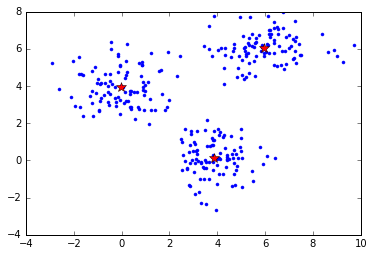

Within Set Sum of Squared Error = 378.1981959539458
Iteration73
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


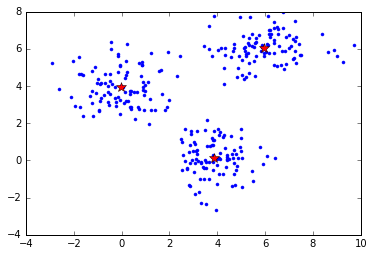

Within Set Sum of Squared Error = 378.1981959539458
Iteration74
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


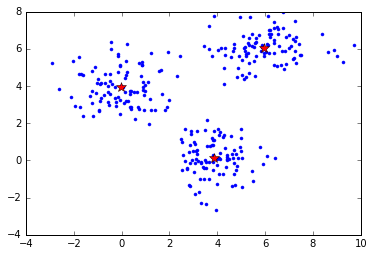

Within Set Sum of Squared Error = 378.1981959539458
Iteration75
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


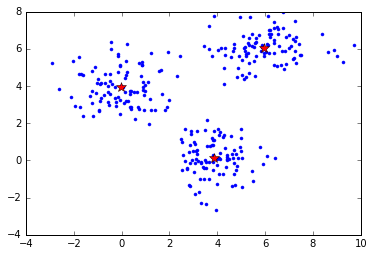

Within Set Sum of Squared Error = 378.1981959539458
Iteration76
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


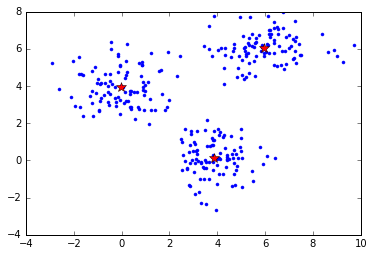

Within Set Sum of Squared Error = 378.1981959539458
Iteration77
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


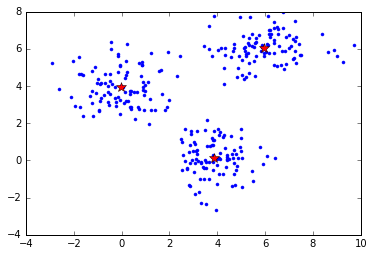

Within Set Sum of Squared Error = 378.1981959539458
Iteration78
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


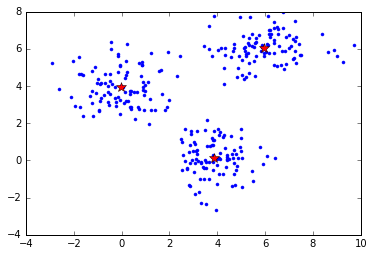

Within Set Sum of Squared Error = 378.1981959539458
Iteration79
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


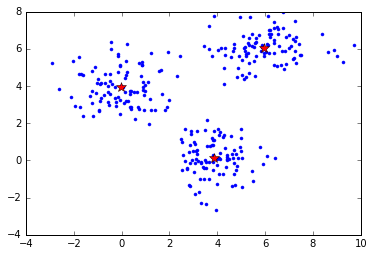

Within Set Sum of Squared Error = 378.1981959539458
Iteration80
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


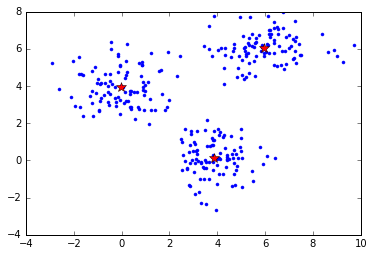

Within Set Sum of Squared Error = 378.1981959539458
Iteration81
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


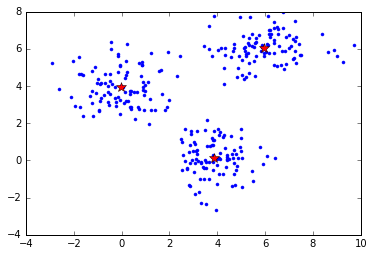

Within Set Sum of Squared Error = 378.1981959539458
Iteration82
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


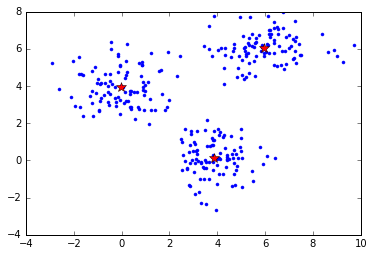

Within Set Sum of Squared Error = 378.1981959539458
Iteration83
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


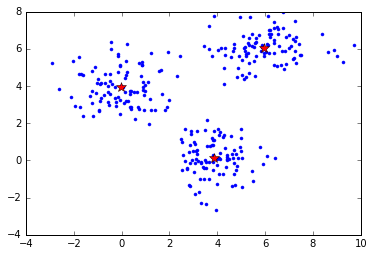

Within Set Sum of Squared Error = 378.1981959539458
Iteration84
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


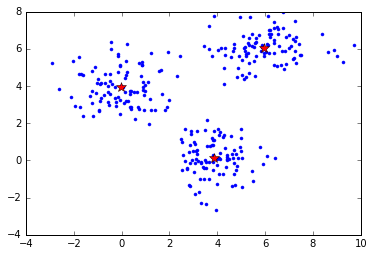

Within Set Sum of Squared Error = 378.1981959539458
Iteration85
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


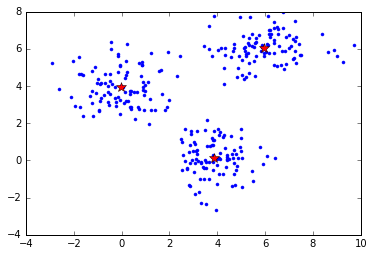

Within Set Sum of Squared Error = 378.1981959539458
Iteration86
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


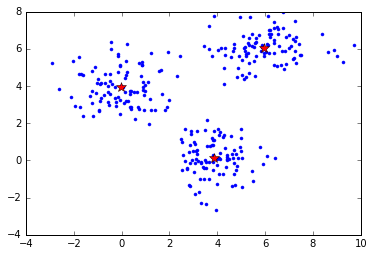

Within Set Sum of Squared Error = 378.1981959539458
Iteration87
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


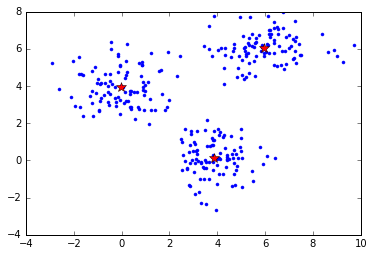

Within Set Sum of Squared Error = 378.1981959539458
Iteration88
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


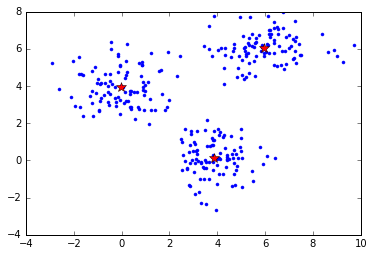

Within Set Sum of Squared Error = 378.1981959539458
Iteration89
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


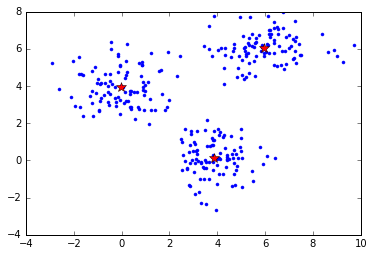

Within Set Sum of Squared Error = 378.1981959539458
Iteration90
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


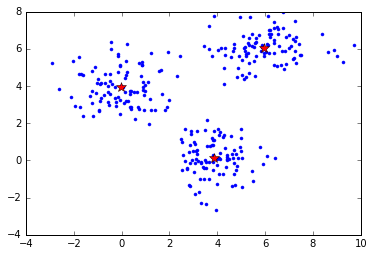

Within Set Sum of Squared Error = 378.1981959539458
Iteration91
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


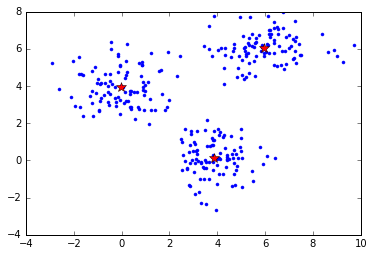

Within Set Sum of Squared Error = 378.1981959539458
Iteration92
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


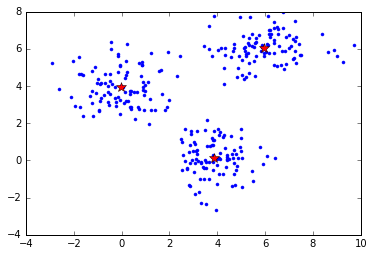

Within Set Sum of Squared Error = 378.1981959539458
Iteration93
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


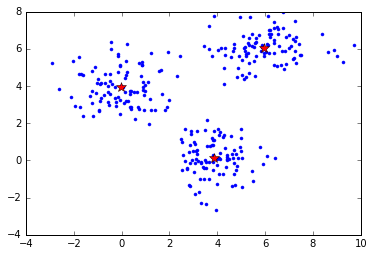

Within Set Sum of Squared Error = 378.1981959539458
Iteration94
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


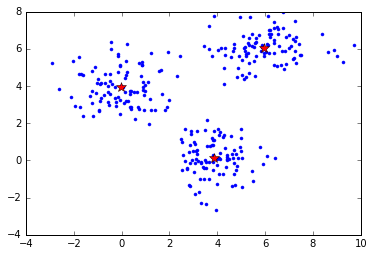

Within Set Sum of Squared Error = 378.1981959539458
Iteration95
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


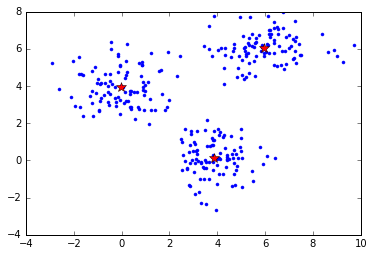

Within Set Sum of Squared Error = 378.1981959539458
Iteration96
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


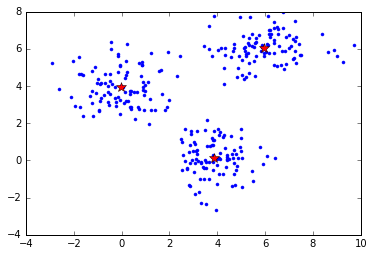

Within Set Sum of Squared Error = 378.1981959539458
Iteration97
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


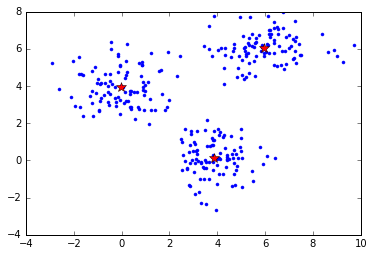

Within Set Sum of Squared Error = 378.1981959539458
Iteration98
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


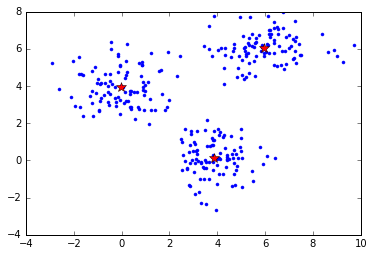

Within Set Sum of Squared Error = 378.1981959539458
Iteration99
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


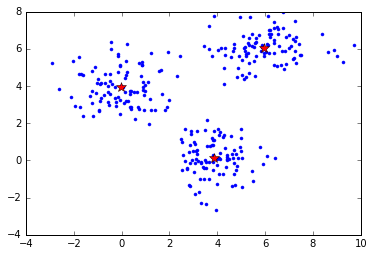

Within Set Sum of Squared Error = 378.1981959539458
Final Results:
[[-0.04364292  3.95200914]
 [ 3.87527608  0.11408864]
 [ 5.9744049   6.06374972]]


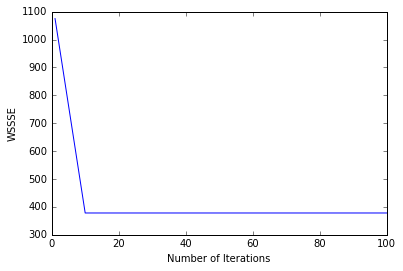

In [112]:
import numpy as np
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("kmeans2_data.txt").cache()
parsedData2 = D.map(lambda line: array([float(x) for x in line.split(' ')]))

iter_num = 0
errorlist = []
for i in range(100):
    cBroadcast = sc.broadcast(centroids)
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    errorval = D.map(error).reduce(lambda x, y: (x+y))
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    print ("Iteration" + str(iter_num))
    errorlist += (iter_num, errorval)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print (centroids)
    plot_iteration(centroids)
    print("Within Set Sum of Squared Error = " + str(errorval))

print ("Final Results:")
print (centroids)

import matplotlib.pyplot as plt
pointstoplot = errorlist[1], errorlist[19], errorlist[39], errorlist[59], errorlist[79], errorlist[99], errorlist[199]
xaxis = 1, 10, 20, 30, 40, 50, 100
plt.plot(xaxis, pointstoplot)
plt.ylabel('WSSSE')
plt.xlabel('Number of Iterations')
plt.show()

#### COMMENTS

Using the broadcast feature in spark allows us to "broadcast" the centroid values out to the mappers.  This creates efficient processing as the centroids are stored on each mapper instead of having to ship it each time. Theoretically, this should produce increased speed, however with our small dataset, the time it takes to broadcast the values is actually an slowdown in performance.  With significantly larger datasets, we would see a pickup in speed as the increased time taken to broadcast the centroids will produce quicker iteration speed.

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [100]:
## Code goes here

In [101]:
## Drivers & Runners

In [102]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


In [105]:
np.random.seed(0)
x = np.random.uniform(-4, 4, 100)
noise = np.random.normal(0, 2, 100)
y = (x * w[0] + w[1] + noise)
data = list(zip(y, x))

np.savetxt('training.txt',data,delimiter = ',')

In [108]:
np.random.seed(1)
x1 = np.random.uniform(-4, 4, 100)
noise = np.random.normal(0, 2, 100)
y1 = (x1 * w[0] + w[1] + noise)
data = list(zip(y1, x1))

np.savetxt('testing.txt',data,delimiter = ',')

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

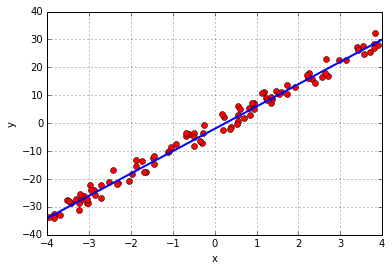

In [106]:
dataPlot('training.txt',w)

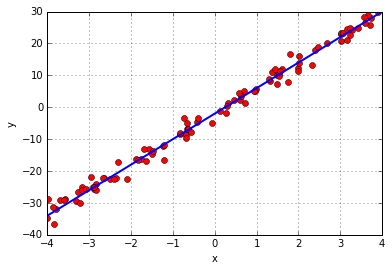

In [109]:
dataPlot('testing.txt',w)

In [115]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("training.txt")
parsedData = data.map(parsePoint)
data2= sc.textFile("testing.txt")
parsedDatatest= data2.map(parsePoint)

# Build the model
model = LinearRegressionWithSGD.train(parsedData, intercept=True, iterations=50)
print (model)

#scoring the training and testing datasets
valuesAndPredsTrain = parsedData.map(lambda p: (p.label, model.predict(p.features)))
valuesAndPredsTest = parsedDatatest.map(lambda p: (p.label, model.predict(p.features)))


#calculating MSE for train
"""MSE = valuesAndPredsTrain.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPredsTrain.count()
print("Mean Squared Error Train = " + str(MSE))

#calculating MSE for test
MSE1 = valuesAndPredsTest.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPredsTest.count()
print("Mean Squared Error Test = " + str(MSE1))

#Python 3 error with lambda function, can't get it to work
"""

(weights=[7.98393748404], intercept=-1.6187449131887346)


'MSE = valuesAndPredsTrain.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPredsTrain.count()\nprint("Mean Squared Error Train = " + str(MSE))\n\n#calculating MSE for test\nMSE1 = valuesAndPredsTest.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPredsTest.count()\nprint("Mean Squared Error Test = " + str(MSE1))\n\n#Python 3 error with lambda function, can\'t get it to work\n'

In [111]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In [112]:
def iterationsPlot(fileName, truew):
    x = [-4, 4]
    
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    data = sc.textFile(fileName).map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
    n = data.count()
    
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print ("Mean Squared Error after 0 iterations: " + str(squared_error/n))
    

    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'g--', label="After 2 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print ("Mean Squared Error after 2 iterations: " + str(squared_error/n))
    
    w = linearRegressionGD(data, w, iterations=4)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'm--', label="After 4 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print ("Mean Squared Error after 4 iterations: " + str(squared_error/n))
    
    w = linearRegressionGD(data, w, iterations=6)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 6 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print ("Mean Squared Error after 6 iterations: " + str(squared_error/n))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

Mean Squared Error after 0 iterations: 464.394955261
Mean Squared Error after 2 iterations: 27.0859380611
Mean Squared Error after 4 iterations: 4.9932567759
Mean Squared Error after 6 iterations: 4.25056900765


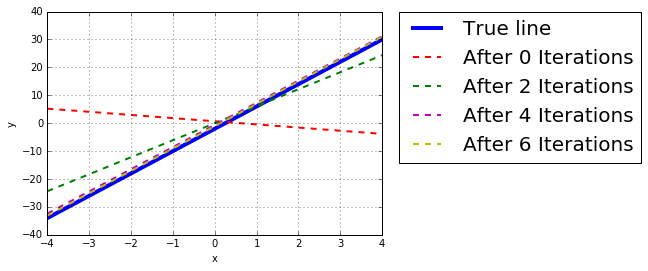

In [113]:
iterationsPlot('training.txt',w)

#### COMMENTS

It seems like 4 iterations gets us a good enough prediction as the MSE doesn't drop significantly from the 4 iterations model compared to the 6 iterations model.  In the plot above we can see that the True Line, 4 iterations model, and 6 iterations model are all basically the same.  

<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [103]:
## Code goes here

In [104]:
## Drivers & Runners

In [105]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [106]:
## Code goes here

In [107]:
## Drivers & Runners

In [108]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>